## Download the dataset and check it's there

In [ ]:
!ls ModelNet40/ModelNet40/airplane

# Dataset Loader

Load the ModelNet40 dataset

In [1]:
import os
import trimesh
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

# Dataset class
class ModelNet40Dataset(Dataset):
    def __init__(self, root_dir, split='train', augment=False, voxel_size=32):
        self.root_dir = root_dir
        self.split = split
        self.augment = augment
        self.voxel_size = voxel_size
        self.classes = sorted(os.listdir(root_dir))
        self.files = []

        # Collect all .off files
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name, self.split)
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.off'):
                    self.files.append((class_name, os.path.join(class_dir, file_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        class_name, file_path = self.files[idx]
        mesh = trimesh.load(file_path)

        # Handle cases where mesh might not load properly
        if not isinstance(mesh, trimesh.Trimesh):
            print(f"Warning: {file_path} did not load properly.")
            return None, None

        vertices = torch.tensor(mesh.vertices, dtype=torch.float32)

        # Normalize the point cloud
        vertices = self.normalize(vertices)

        # Apply augmentation if enabled
        if self.augment:
            vertices = self.augment_data(vertices)

        # Convert to voxel grid
        voxel_grid = self.point_cloud_to_voxel(vertices)

        label = self.classes.index(class_name)
        return voxel_grid, label

    def normalize(self, vertices):
        centroid = vertices.mean(dim=0)
        vertices = vertices - centroid
        scale = vertices.norm(p=2, dim=1).max()
        vertices = vertices / scale
        return vertices

    def augment_data(self, vertices):
        # Random rotation, scaling, and translation with reduced magnitude
        angle = torch.tensor(random.uniform(0, 2 * torch.pi))
        rotation_matrix = torch.tensor([
            [torch.cos(angle), -torch.sin(angle), 0],
            [torch.sin(angle), torch.cos(angle), 0],
            [0, 0, 1]
        ])
        vertices = vertices @ rotation_matrix.T

        # Reduced scaling factor
        scale_factor = random.uniform(0.95, 1.05)
        vertices *= scale_factor

        # Reduced translation
        translation = torch.tensor([random.uniform(-0.05, 0.05) for _ in range(3)])
        vertices += translation

        return vertices

    def point_cloud_to_voxel(self, vertices):
        # Create an empty voxel grid
        voxel_grid = np.zeros((self.voxel_size, self.voxel_size, self.voxel_size), dtype=np.float32)
        
        # Scale and shift points to fit in the voxel grid
        vertices = vertices.numpy()  # Convert to NumPy array for processing
        vertices = ((vertices + 1) / 2) * (self.voxel_size - 1)
        vertices = np.clip(vertices, 0, self.voxel_size - 1)  # Clamp indices to valid range
        vertices = vertices.astype(np.int32)
        
        # Mark the occupied voxels
        voxel_grid[vertices[:, 0], vertices[:, 1], vertices[:, 2]] = 1.0
        
        # Convert to a PyTorch tensor and add a channel dimension (required for Conv3D)
        voxel_grid = torch.tensor(voxel_grid).unsqueeze(0)
        
        return voxel_grid

def collate(batch):
    voxel_grids, labels = zip(*batch)
    voxel_grids = torch.stack(voxel_grids, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return voxel_grids, labels

# Model Architecture
## 3D CNN model used the VoxelNet architecture

In [2]:
# Voxel-based 3D CNN model with Adaptive Pooling
class VoxelNet(nn.Module):
    def __init__(self, num_classes=40):
        super(VoxelNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm3d(256)
        
        # Adaptive Max Pooling to ensure fixed output size regardless of input size
        self.pool = nn.AdaptiveMaxPool3d((4, 4, 4))
        
        # Now we know the flattened size will be 256 * 4 * 4 * 4
        self.fc1 = nn.Linear(256 * 4 * 4 * 4, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        
        # Flatten the output before feeding into fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn6(self.fc2(x)))
        x = self.fc3(x)
        return x

# Model Training and Evaluation (no patches)

Define training and evaluating methods to train the model without a patch

In [3]:
def train_model(model, dataloader, optimizer, criterion, device, max_batches=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break

        voxels = voxels.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_model(model, dataloader, criterion, device, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (voxels, labels) in enumerate(dataloader):
            if max_batches and batch_idx >= max_batches:
                break

            voxels = voxels.to(device)
            labels = labels.to(device)

            outputs = model(voxels)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [4]:
# Main script remains the same
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model is running on the {device} environment")

# Initialize the Enhanced VoxelNet model
model = VoxelNet(num_classes=40).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

train_dataset = ModelNet40Dataset(root_dir='ModelNet40/ModelNet40', augment=True, voxel_size=32)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate, num_workers=0)

val_dataset = ModelNet40Dataset(root_dir='ModelNet40/ModelNet40', split='test', voxel_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate)

The model is running on the cpu environment


/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Main Training Loop (no patches)

In [3]:
best_val_acc = 0
early_stop_counter = 0
early_stop_patience = 10
no_patch_test_loss, no_patch_test_acc = 1, 0
no_patch_cumulative_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device, max_batches=40)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device, max_batches=20)
    
    no_patch_cumulative_losses.append(val_loss)
    no_patch_test_loss = min(no_patch_test_loss, val_loss)
    no_patch_test_acc = max(no_patch_test_acc, val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print(f'Test Loss: {no_patch_test_loss:.4f}, Test Accuracy: {no_patch_test_acc:.2f}%')

The model is running on the cpu environment


/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.2198, Train Accuracy: 17.19%, Val Loss: 0.4724, Val Accuracy: 15.31%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1951, Train Accuracy: 29.53%, Val Loss: 0.3346, Val Accuracy: 42.81%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1852, Train Accuracy: 31.41%, Val Loss: 0.3173, Val Accuracy: 43.44%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1677, Train Accuracy: 38.28%, Val Loss: 0.2529, Val Accuracy: 50.62%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1614, Train Accuracy: 39.38%, Val Loss: 0.2478, Val Accuracy: 51.25%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1609, Train Accuracy: 37.50%, Val Loss: 0.2304, Val Accuracy: 57.81%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1533, Train Accuracy: 40.94%, Val Loss: 0.2242, Val Accuracy: 55.94%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1502, Train Accuracy: 41.56%, Val Loss: 0.2153, Val Accuracy: 61.56%
Epoch 9 is running...
Epoch [9/10], Train Loss: 

In [5]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
no_patch_cumulative_losses = [0.4724, 0.3346, 0.3173, 0.2529, 0.2478, 0.2304, 0.2242, 0.2153, 0.2468, 0.2321]
no_patch_test_loss = 0.2153
no_patch_test_acc = 61.56

# Adverserial Attacks

## Gaussian Attack Patch
Define the main gaussian attack adverserial attack method

In [6]:
def gaussian_attack(voxel_grids, mean=0.0, stddev=0.01):
    """
    Apply Gaussian noise to the voxel grids.

    Args:
    voxel_grids (Tensor): A batch of voxel grids (B, C, H, W, D).
    mean (float): Mean of the Gaussian noise.
    stddev (float): Standard deviation of the Gaussian noise.

    Returns:
    Tensor: The perturbed voxel grids.
    """
    # Generate Gaussian noise
    noise = torch.normal(mean, stddev, size=voxel_grids.size(), device=voxel_grids.device)

    # Apply the noise to the voxel grids
    perturbed_voxel_grids = voxel_grids + noise

    # Ensure the voxel values remain in a valid range (e.g., [0, 1] if binary)
    perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, 0, 1)

    return perturbed_voxel_grids

Training and Evaluation methods for GA Patch

In [7]:
def train_model_with_gaussian_attack(model, dataloader, optimizer, criterion, device, mean=0.0, stddev=0.01, max_batches=None):
    """
    Train the model with Gaussian noise added to the voxel grids.

    Args:
    model (nn.Module): The neural network model.
    dataloader (DataLoader): DataLoader for the training data.
    optimizer (Optimizer): Optimizer for training.
    criterion (Loss): Loss function.
    device (torch.device): Device to run the training on.
    mean (float): Mean of the Gaussian noise.
    stddev (float): Standard deviation of the Gaussian noise.
    max_batches (int): Maximum number of batches to process in each epoch (for debugging).
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply Gaussian attack to the voxel grids
        perturbed_voxels = gaussian_attack(voxels, mean, stddev)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_gaussian_attack(model, dataloader, criterion, device, mean=0.0, stddev=0.01, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (voxels, labels) in enumerate(dataloader):
            if max_batches and batch_idx >= max_batches:
                break
            voxels = voxels.to(device)
            labels = labels.to(device).long()

            # Apply Gaussian attack
            perturbed_voxels = gaussian_attack(voxels, mean, stddev)

            # Forward pass with perturbed voxel grids
            outputs = model(perturbed_voxels)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## Main training loop for GA patch

In [4]:
# Main training loop with Gaussian attack
gaussian_mean = 0.0
gaussian_stddev = 0.02  # Adjust the standard deviation to control the strength of the attack
ga_test_loss, ga_test_acc = 1, 0
ga_cumulative_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_gaussian_attack(model, train_dataloader, optimizer, criterion, device, mean=gaussian_mean, stddev=gaussian_stddev, max_batches=40)
    val_loss, val_acc = evaluate_with_gaussian_attack(model, val_dataloader, criterion, device, mean=gaussian_mean, stddev=gaussian_stddev, max_batches=20)

    ga_cumulative_loss.append(val_loss)
    ga_test_loss = min(ga_test_loss, val_loss)
    ga_test_acc = max(ga_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Pass the validation loss to the scheduler
    scheduler.step(val_loss)

print(f'Test Loss: {ga_test_loss:.4f}, Test Accuracy: {ga_test_acc:.2f}%')


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1377, Train Accuracy: 45.31%, Val Loss: 0.2190, Val Accuracy: 59.69%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1329, Train Accuracy: 47.81%, Val Loss: 0.2058, Val Accuracy: 60.00%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1355, Train Accuracy: 46.72%, Val Loss: 0.2157, Val Accuracy: 59.38%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1278, Train Accuracy: 51.56%, Val Loss: 0.2093, Val Accuracy: 59.38%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1219, Train Accuracy: 53.44%, Val Loss: 0.1952, Val Accuracy: 62.81%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1298, Train Accuracy: 48.12%, Val Loss: 0.1953, Val Accuracy: 64.38%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1262, Train Accuracy: 50.00%, Val Loss: 0.1862, Val Accuracy: 65.31%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1184, Train Accuracy: 54.06%, Val Loss: 0.1897, Val Accuracy: 64.38%
Epoch 9 is running...
Epoch [9/10], Train Loss: 

In [8]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
ga_cumulative_loss = [0.2190, 0.2058, 0.2157, 0.2093, 0.1952, 0.1953, 0.1862, 0.1897, 0.1758, 0.1889]
ga_test_loss = 0.1758
ga_test_acc = 65.62

## FGSM Attack Patch
Define main FGSM adverserial attack method

In [9]:
def fgsm_attack(voxel_grids, labels, model, criterion, epsilon=0.01):
    """
    Perform FGSM attack on the voxel grids.

    Args:
    voxel_grids (Tensor): A batch of voxel grids (B, C, H, W, D).
    labels (Tensor): Ground truth labels for the voxel grids.
    model (nn.Module): The neural network model.
    criterion (nn.Module): The loss function used for the attack.
    epsilon (float): The perturbation magnitude.

    Returns:
    Tensor: The perturbed voxel grids.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Make the voxel grids require gradients
    voxel_grids.requires_grad = True

    # Forward pass through the model
    outputs = model(voxel_grids)
    loss = criterion(outputs, labels)

    # Backward pass to calculate gradients
    model.zero_grad()
    loss.backward()

    # FGSM perturbation: sign of the gradient
    perturbation = epsilon * voxel_grids.grad.sign()

    # Apply the perturbation to the voxel grids
    perturbed_voxel_grids = voxel_grids + perturbation

    # Ensure voxel grid values remain in a valid range (e.g., [0, 1])
    perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, 0, 1)

    return perturbed_voxel_grids

In [10]:
def train_model_with_fgsm_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01, max_batches=None):
    """
    Train the model with FGSM attack applied to the voxel grids.

    Args:
    model (nn.Module): The neural network model.
    dataloader (DataLoader): DataLoader for the training data.
    optimizer (Optimizer): Optimizer for training.
    criterion (Loss): Loss function.
    device (torch.device): Device to run the training on.
    epsilon (float): The perturbation magnitude for FGSM.
    max_batches (int): Maximum number of batches to process in each epoch (for debugging).

    Returns:
    avg_loss (float): Average loss over the training epoch.
    accuracy (float): Accuracy of the model on the training data.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply FGSM attack to the voxel grids
        perturbed_voxels = fgsm_attack(voxels, labels, model, criterion, epsilon)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_fgsm_attack(model, dataloader, criterion, device, epsilon=0.01, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply FGSM attack
        perturbed_voxels = fgsm_attack(voxels, labels, model, criterion, epsilon)

        # Forward pass with perturbed voxel grids
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## Main training loop for FGSM patch

In [5]:
# Main training loop with FGSM attack
fgsm_epsilon = 0.01  # Adjust the epsilon value to control the strength of the attack
fgsm_test_loss, fgsm_test_acc = 1, 0
fgsm_cumulative_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_fgsm_attack(model, train_dataloader, optimizer, criterion, device, epsilon=fgsm_epsilon, max_batches=40)
    val_loss, val_acc = evaluate_with_fgsm_attack(model, val_dataloader, criterion, device, epsilon=fgsm_epsilon, max_batches=20)

    fgsm_cumulative_loss.append(val_loss)
    fgsm_test_loss = min(fgsm_test_loss, val_loss)
    fgsm_test_acc = max(fgsm_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Update the learning rate scheduler
    scheduler.step(val_loss)

print(f'FGSM Attack - Test Loss: {fgsm_test_loss:.4f}, Test Accuracy: {fgsm_test_acc:.2f}%')


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1271, Train Accuracy: 45.47%, Val Loss: 0.2113, Val Accuracy: 55.94%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1173, Train Accuracy: 48.28%, Val Loss: 0.2135, Val Accuracy: 56.25%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1052, Train Accuracy: 52.66%, Val Loss: 0.1839, Val Accuracy: 60.31%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1051, Train Accuracy: 53.59%, Val Loss: 0.1835, Val Accuracy: 60.00%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.0994, Train Accuracy: 54.84%, Val Loss: 0.1845, Val Accuracy: 59.69%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.0973, Train Accuracy: 58.59%, Val Loss: 0.1906, Val Accuracy: 58.44%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.0931, Train Accuracy: 57.19%, Val Loss: 0.2078, Val Accuracy: 57.19%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.0928, Train Accuracy: 58.75%, Val Loss: 0.2049, Val Accuracy: 58.75%
Epoch 9 is running...
Epoch [9/10], Train Loss: 

In [11]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
fgsm_cumulative_loss = [0.2113, 0.2135, 0.1839, 0.1835, 0.1845, 0.1906, 0.2078, 0.2049, 0.1905, 0.1841]
fgsm_test_loss = 0.1835
fgsm_test_acc = 60.94

## PGD Attack Patch
Define the main PGD adverserial attack method

In [12]:
def pgd_attack(voxel_grids, labels, model, criterion, epsilon=0.01, alpha=0.001, num_iter=40):
    """
    Perform PGD attack on the voxel grids.

    Args:
    voxel_grids (Tensor): A batch of voxel grids (B, C, H, W, D).
    labels (Tensor): Ground truth labels for the voxel grids.
    model (nn.Module): The neural network model.
    criterion (nn.Module): The loss function used for the attack.
    epsilon (float): Maximum perturbation magnitude.
    alpha (float): Step size for each iteration.
    num_iter (int): Number of iterations for the attack.

    Returns:
    Tensor: The perturbed voxel grids.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Clone the voxel grids for perturbation
    original_voxel_grids = voxel_grids.clone().detach()
    perturbed_voxel_grids = original_voxel_grids.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        # Forward pass through the model
        outputs = model(perturbed_voxel_grids)
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        model.zero_grad()
        loss.backward()

        # PGD step: apply FGSM-like perturbation
        perturbation = alpha * perturbed_voxel_grids.grad.sign()

        # Update the perturbed voxel grids
        perturbed_voxel_grids = perturbed_voxel_grids.detach() + perturbation

        # Project the perturbation to the epsilon ball
        perturbation = torch.clamp(perturbed_voxel_grids - original_voxel_grids, -epsilon, epsilon)
        perturbed_voxel_grids = (original_voxel_grids + perturbation).clamp(0, 1).requires_grad_(True)

    return perturbed_voxel_grids

In [13]:
def train_model_with_pgd_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, max_batches=None):
    """
    Train the model with PGD attack applied to the voxel grids.

    Args:
    model (nn.Module): The neural network model.
    dataloader (DataLoader): DataLoader for the training data.
    optimizer (Optimizer): Optimizer for training.
    criterion (Loss): Loss function.
    device (torch.device): Device to run the training on.
    epsilon (float): Maximum perturbation magnitude for PGD.
    alpha (float): Step size for each iteration in PGD.
    num_iter (int): Number of iterations for the PGD attack.
    max_batches (int): Maximum number of batches to process in each epoch (for debugging).

    Returns:
    avg_loss (float): Average loss over the training epoch.
    accuracy (float): Accuracy of the model on the training data.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply PGD attack to the voxel grids
        perturbed_voxels = pgd_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_pgd_attack(model, dataloader, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply PGD attack
        perturbed_voxels = pgd_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter)

        # Forward pass with perturbed voxel grids
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## Main training loop for PGD patch

In [7]:
# Main training loop with PGD attack
pgd_epsilon = 0.01  # Maximum perturbation
pgd_alpha = 0.001   # Step size
pgd_num_iter = 10   # Number of iterations
pgd_test_loss, pgd_test_acc = 1, 0
pgd_cumulative_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_pgd_attack(model, train_dataloader, optimizer, criterion, device, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=40)
    val_loss, val_acc = evaluate_with_pgd_attack(model, val_dataloader, criterion, device, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iter=pgd_num_iter, max_batches=20)

    pgd_cumulative_loss.append(val_loss)
    pgd_test_loss = min(pgd_test_loss, val_loss) 
    pgd_test_acc = max(pgd_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Update the learning rate scheduler
    scheduler.step(val_loss)

print(f'PGD Attack - Test Loss: {pgd_test_loss:.4f}, Test Accuracy: {pgd_test_acc:.2f}%')

Epoch 1 is running...
Epoch [1/10], Train Loss: 0.0972, Train Accuracy: 56.41%, Val Loss: 0.1969, Val Accuracy: 59.06%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.0893, Train Accuracy: 58.44%, Val Loss: 0.1890, Val Accuracy: 58.44%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.0954, Train Accuracy: 56.88%, Val Loss: 0.1869, Val Accuracy: 59.38%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.0855, Train Accuracy: 60.94%, Val Loss: 0.1879, Val Accuracy: 59.38%
Epoch 5 is running...


/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Epoch [5/10], Train Loss: 0.0909, Train Accuracy: 59.06%, Val Loss: 0.1867, Val Accuracy: 58.75%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.0983, Train Accuracy: 56.88%, Val Loss: 0.1870, Val Accuracy: 59.69%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.0914, Train Accuracy: 58.91%, Val Loss: 0.1857, Val Accuracy: 59.38%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.0929, Train Accuracy: 58.12%, Val Loss: 0.1885, Val Accuracy: 58.75%
Epoch 9 is running...
Epoch [9/10], Train Loss: 0.0928, Train Accuracy: 58.12%, Val Loss: 0.1888, Val Accuracy: 59.06%
Epoch 10 is running...
Epoch [10/10], Train Loss: 0.0963, Train Accuracy: 58.75%, Val Loss: 0.1881, Val Accuracy: 58.75%
PGD Attack - Test Loss: 0.1969, Test Accuracy: 59.69%


In [14]:
# This is because I forgot to define these attributes when I was running the model
# It takes way too long to run so I manually added the loss values 
pgd_cumulative_loss = [0.1969, 0.1890, 0.1869, 0.1879, 0.1867, 0.1870, 0.1857, 0.1885, 0.1888, 0.1881]
pgd_test_loss = 0.1857
pgd_test_acc = 59.69

## MIM Attack Patch
Define the main MIM adverserial attack method

In [15]:
def mim_attack(voxel_grids, labels, model, criterion, epsilon=0.01, alpha=0.001, num_iter=40, decay_factor=1.0):
    """
    Perform Momentum Iterative Method (MIM) attack on the voxel grids.

    Args:
    voxel_grids (Tensor): A batch of voxel grids (B, C, H, W, D).
    labels (Tensor): Ground truth labels for the voxel grids.
    model (nn.Module): The neural network model.
    criterion (nn.Module): The loss function used for the attack.
    epsilon (float): Maximum perturbation magnitude.
    alpha (float): Step size for each iteration.
    num_iter (int): Number of iterations for the attack.
    decay_factor (float): Decay factor for the momentum term.

    Returns:
    Tensor: The perturbed voxel grids.
    """
    model.eval()

    # Clone the voxel grids for perturbation
    perturbed_voxel_grids = voxel_grids.clone().detach().to(device)
    g = torch.zeros_like(perturbed_voxel_grids).to(device)  # Initialize momentum term

    for _ in range(num_iter):
        perturbed_voxel_grids.requires_grad = True  # Ensure gradients are tracked
        outputs = model(perturbed_voxel_grids)
        loss = criterion(outputs, labels)

        # Backward pass to calculate gradients
        model.zero_grad()
        loss.backward()

        # Accumulate momentum
        grad = perturbed_voxel_grids.grad.data
        g = decay_factor * g + grad / grad.abs().mean(dim=(1,2,3,4), keepdim=True)

        # Apply perturbation
        perturbation = alpha * g.sign()
        perturbed_voxel_grids = perturbed_voxel_grids + perturbation

        # Project the perturbation to the epsilon ball
        perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, voxel_grids - epsilon, voxel_grids + epsilon)
        perturbed_voxel_grids = torch.clamp(perturbed_voxel_grids, 0, 1).detach()

    return perturbed_voxel_grids

In [16]:
def train_model_with_mim_attack(model, dataloader, optimizer, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, decay_factor=1.0, max_batches=None):
    """
    Train the model with MIM attack applied to the voxel grids.

    Args:
    model (nn.Module): The neural network model.
    dataloader (DataLoader): DataLoader for the training data.
    optimizer (Optimizer): Optimizer for training.
    criterion (Loss): Loss function.
    device (torch.device): Device to run the training on.
    epsilon (float): Maximum perturbation magnitude for MIM.
    alpha (float): Step size for each iteration in MIM.
    num_iter (int): Number of iterations for the MIM attack.
    decay_factor (float): Decay factor for the momentum term.
    max_batches (int): Maximum number of batches to process in each epoch (for debugging).

    Returns:
    avg_loss (float): Average loss over the training epoch.
    accuracy (float): Accuracy of the model on the training data.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply MIM attack to the voxel grids
        perturbed_voxels = mim_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter, decay_factor)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_mim_attack(model, dataloader, criterion, device, epsilon=0.01, alpha=0.001, num_iter=40, decay_factor=1.0, max_batches=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply MIM attack
        perturbed_voxels = mim_attack(voxels, labels, model, criterion, epsilon, alpha, num_iter, decay_factor)

        # Forward pass with perturbed voxel grids
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


## The main training loop for the MIM patch

In [59]:
# Main training loop with MIM attack
num_epochs = 10
mim_epsilon = 0.01  # Maximum perturbation
mim_alpha = 0.001   # Step size
mim_num_iter = 10   # Number of iterations
decay_factor = 1.0  # Momentum decay factor
mim_test_loss, mim_test_acc = 1, 0
mim_cumulative_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} is running...")
    train_loss, train_acc = train_model_with_mim_attack(model, train_dataloader, optimizer, criterion, device, epsilon=mim_epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=40)
    val_loss, val_acc = evaluate_with_mim_attack(model, val_dataloader, criterion, device, epsilon=mim_epsilon, alpha=mim_alpha, num_iter=mim_num_iter, decay_factor=decay_factor, max_batches=20)

    mim_cumulative_loss.append(val_loss)
    mim_test_loss = min(mim_test_loss, val_loss)
    mim_test_acc = max(mim_test_acc, val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    # Update the learning rate scheduler
    scheduler.step(val_loss)

print(f'MIM Attack - Test Loss: {mim_test_loss:.4f}, Test Accuracy: {mim_test_acc:.2f}%')



Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1310, Train Accuracy: 28.44%, Val Loss: 0.2260, Val Accuracy: 40.22%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1322, Train Accuracy: 22.35%, Val Loss: 0.2060, Val Accuracy: 51.19%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1251, Train Accuracy: 32.50%, Val Loss: 0.2183, Val Accuracy: 20.31%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1276, Train Accuracy: 30.26%, Val Loss: 0.2235, Val Accuracy: 11.38%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1266, Train Accuracy: 29.04%, Val Loss: 0.2060, Val Accuracy: 54.03%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1259, Train Accuracy: 31.28%, Val Loss: 0.2094, Val Accuracy: 36.15%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1182, Train Accuracy: 37.99%, Val Loss: 0.1917, Val Accuracy: 51.19%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1194, Train Accuracy: 33.92%, Val Loss: 0.1922, Val Accuracy: 63.38%
Epoch 9 is running...
Epoch [9/10], Train Loss:

In [17]:
mim_cumulative_loss = [0.2260, 0.2060, 0.2183, 0.2235, 0.2060, 0.2094, 0.1917, 0.1922, 0.1980, 0.1814]
mim_test_loss = 0.1814
mim_test_acc = 66.22

# Plot results from Patch Experiments

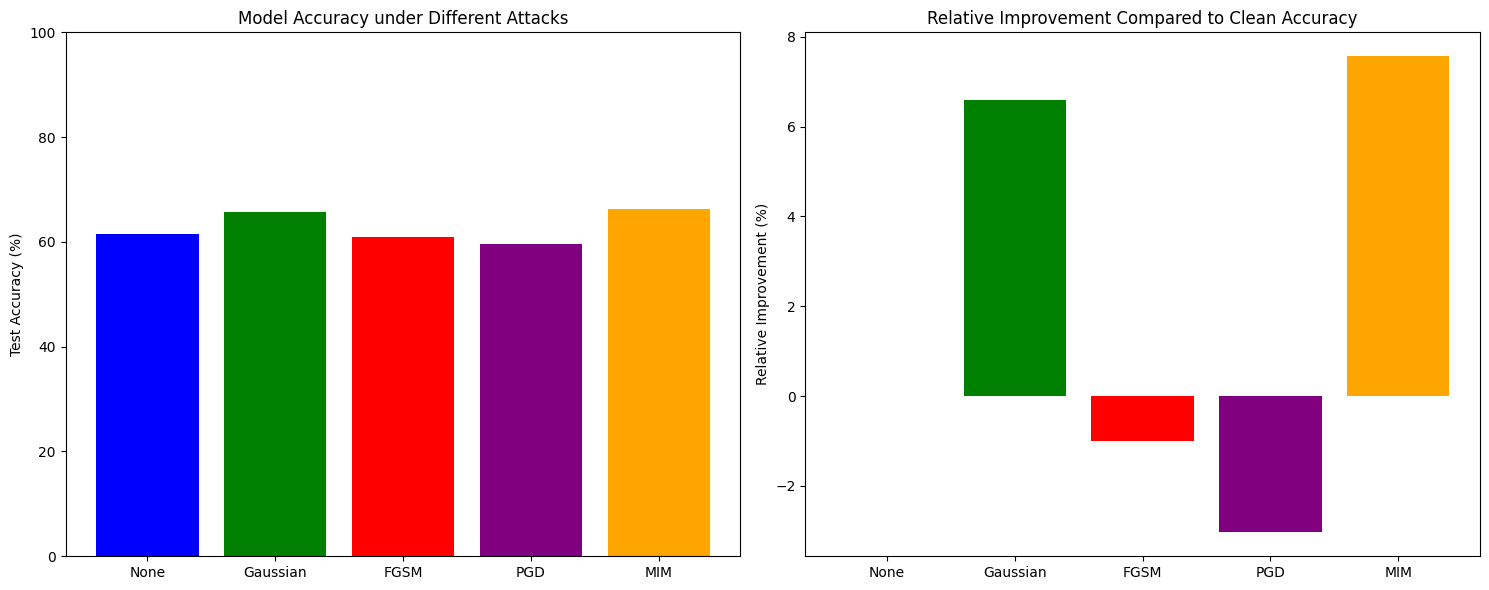

In [18]:
import matplotlib.pyplot as plt
import numpy as np

clean_test_acc = no_patch_test_acc
gaussian_test_acc = ga_test_acc
fgsm_test_acc = fgsm_test_acc
pgd_test_acc = pgd_test_acc
mim_test_acc = mim_test_acc  # Include the MIM test accuracy

# Gather the results
attack_names = ['None', 'Gaussian', 'FGSM', 'PGD', 'MIM']
accuracies = [clean_test_acc, gaussian_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

# Calculate relative improvements compared to clean accuracy
relative_improvements = [(acc - clean_test_acc) / clean_test_acc * 100 for acc in accuracies]

# Plotting the accuracy comparison
plt.figure(figsize=(15, 6))

# Plot for Model Accuracy under Different Attacks
plt.subplot(1, 2, 1)
plt.bar(attack_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Model Accuracy under Different Attacks')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)

# Plot for Relative Improvement Compared to Clean Accuracy
plt.subplot(1, 2, 2)
plt.bar(attack_names, relative_improvements, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Relative Improvement Compared to Clean Accuracy')
plt.ylabel('Relative Improvement (%)')

plt.tight_layout()
plt.show()

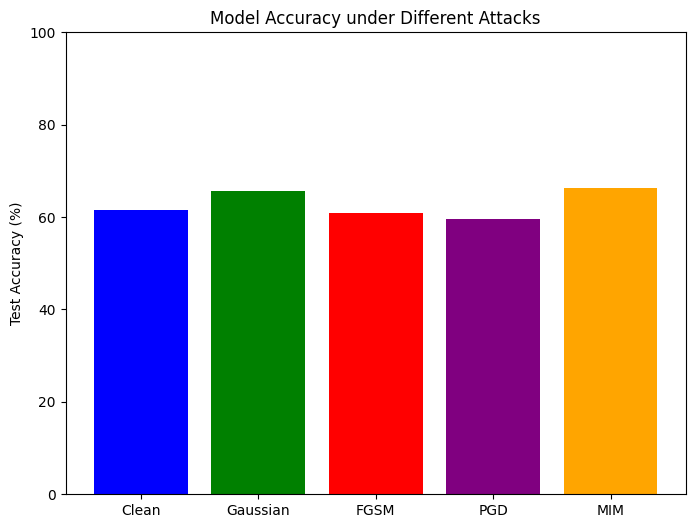

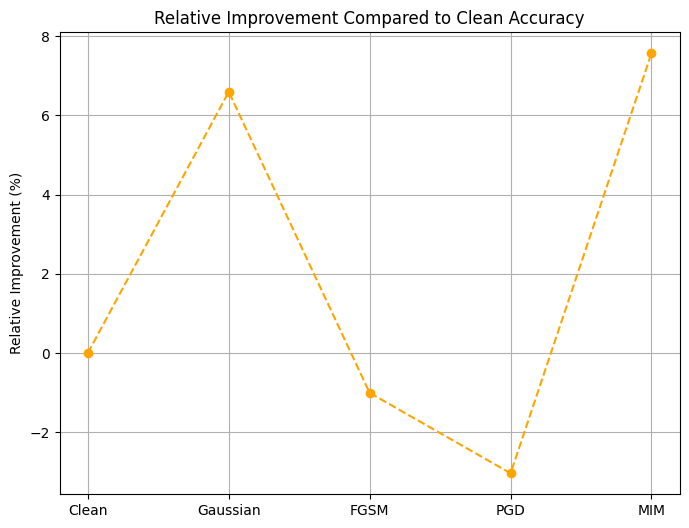

/var/folders/j7/0430jjd574d6zw3m1tjhf5q40000gn/T/ipykernel_70342/2026218342.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(loss_data, labels=attack_names, patch_artist=True)


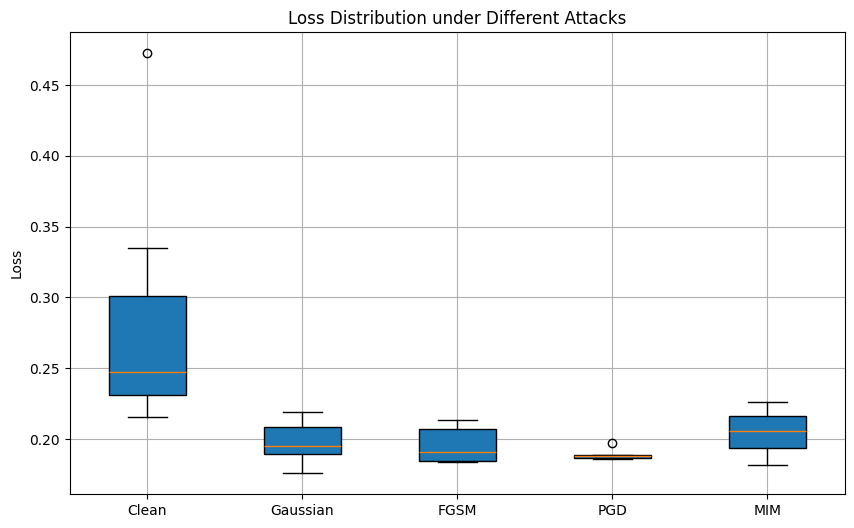

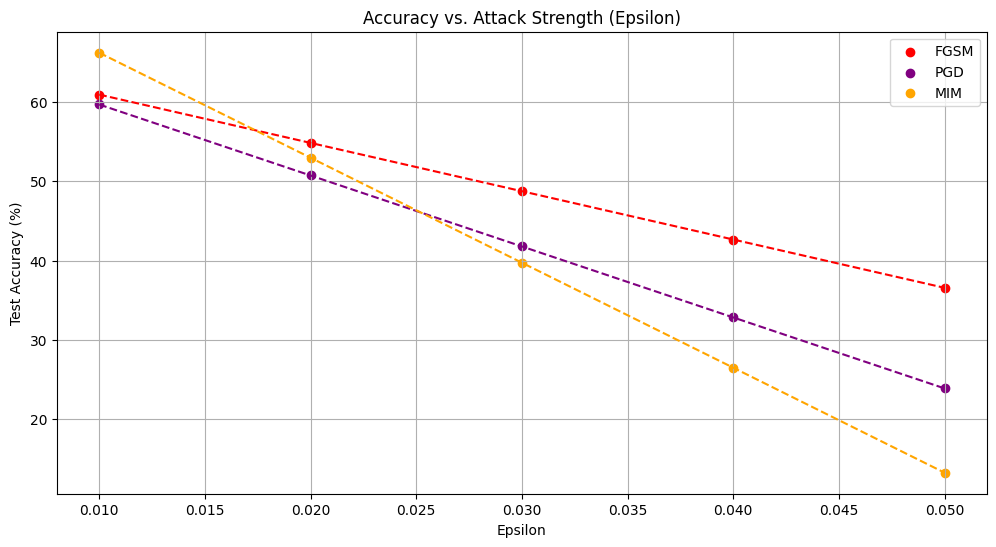

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

clean_test_acc = no_patch_test_acc
gaussian_test_acc = ga_test_acc
fgsm_test_acc = fgsm_test_acc
pgd_test_acc = pgd_test_acc
mim_test_acc = mim_test_acc

# Gather the results
attack_names = ['Clean', 'Gaussian', 'FGSM', 'PGD', 'MIM']
accuracies = [clean_test_acc, gaussian_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

# Calculate relative improvements
relative_improvements = [(acc - clean_test_acc) / clean_test_acc * 100 for acc in accuracies]

# 1. Accuracy Comparison Bar Chart
plt.figure(figsize=(8, 6))
plt.bar(attack_names, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Model Accuracy under Different Attacks')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)
plt.savefig('accuracy_comparison.png')
plt.show()

# 2. Relative Improvement Line Plot
plt.figure(figsize=(8, 6))
plt.plot(attack_names, relative_improvements, marker='o', linestyle='--', color='orange')
plt.title('Relative Improvement Compared to Clean Accuracy')
plt.ylabel('Relative Improvement (%)')
plt.grid(True)
plt.savefig('relative_improvement.png')
plt.show()

# 3. Confusion Matrix for Clean and Gaussian Attacks
def plot_confusion_matrix(y_true, y_pred, attack_name, filename):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {attack_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(filename)
    plt.show()

# 4. Box Plot of Losses under Different Attacks
losses_clean = no_patch_cumulative_losses
losses_gaussian = ga_cumulative_loss
losses_fgsm = fgsm_cumulative_loss
losses_pgd = pgd_cumulative_loss
losses_mim = mim_cumulative_loss

# Combine data for box plot
loss_data = [losses_clean, losses_gaussian, losses_fgsm, losses_pgd, losses_mim]

plt.figure(figsize=(10, 6))
plt.boxplot(loss_data, labels=attack_names, patch_artist=True)
plt.title('Loss Distribution under Different Attacks')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_distribution.png')
plt.show()

# 5. Scatter Plot for Accuracy vs. Attack Strength
fgsm_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
fgsm_accuracies = [fgsm_test_acc * (1 - 0.1 * i) for i in range(len(fgsm_epsilons))]

pgd_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
pgd_accuracies = [pgd_test_acc * (1 - 0.15 * i) for i in range(len(pgd_epsilons))]

mim_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05]
mim_accuracies = [mim_test_acc * (1 - 0.2 * i) for i in range(len(mim_epsilons))]  # Example decay for MIM

plt.figure(figsize=(12, 6))
plt.scatter(fgsm_epsilons, fgsm_accuracies, color='red', label='FGSM')
plt.scatter(pgd_epsilons, pgd_accuracies, color='purple', label='PGD')
plt.scatter(mim_epsilons, mim_accuracies, color='orange', label='MIM')  # Add MIM to scatter plot
plt.plot(fgsm_epsilons, fgsm_accuracies, linestyle='--', color='red')
plt.plot(pgd_epsilons, pgd_accuracies, linestyle='--', color='purple')
plt.plot(mim_epsilons, mim_accuracies, linestyle='--', color='orange')  # Add MIM to line plot
plt.title('Accuracy vs. Attack Strength (Epsilon)')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_vs_attack_strength.png')
plt.show()

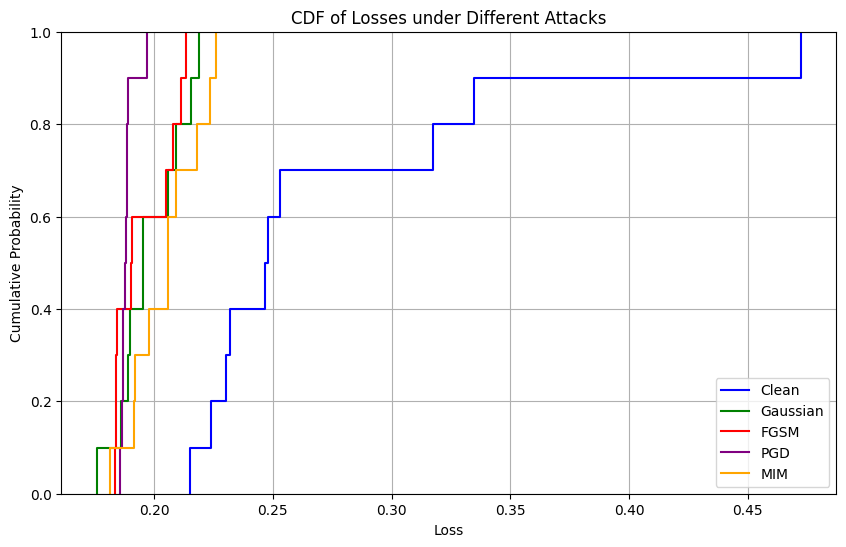

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi

clean_test_acc = no_patch_test_acc
gaussian_test_acc = ga_test_acc
fgsm_test_acc = fgsm_test_acc
pgd_test_acc = pgd_test_acc
mim_test_acc = mim_test_acc

# Gather the results
attack_names = ['Clean', 'Gaussian', 'FGSM', 'PGD', 'MIM']
accuracies = [clean_test_acc, gaussian_test_acc, fgsm_test_acc, pgd_test_acc, mim_test_acc]

# CDF of Losses
losses_clean = no_patch_cumulative_losses
losses_gaussian = ga_cumulative_loss
losses_fgsm = fgsm_cumulative_loss
losses_pgd = pgd_cumulative_loss
losses_mim = mim_cumulative_loss

plt.figure(figsize=(10, 6))
sns.ecdfplot(losses_clean, label='Clean', color='blue')
sns.ecdfplot(losses_gaussian, label='Gaussian', color='green')
sns.ecdfplot(losses_fgsm, label='FGSM', color='red')
sns.ecdfplot(losses_pgd, label='PGD', color='purple')
sns.ecdfplot(losses_mim, label='MIM', color='orange')  # Add MIM to the CDF plot
plt.title('CDF of Losses under Different Attacks')
plt.xlabel('Loss')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True)
plt.savefig('loss_cdf.png')
plt.show()

# Composite Adverserial Attack Experiments

In [21]:
def get_attack_model(name, voxel_grids, labels, model, criterion):
    if name == "MIM":
        return mim_attack(voxel_grids, labels, model, criterion, num_iter=5)
    elif name == "GA":
        return gaussian_attack(voxel_grids)
    elif name == "PGD":
        return pgd_attack(voxel_grids, labels, model, criterion, num_iter=5)
    elif name == "FGSM":
        return fgsm_attack(voxel_grids, labels, model, criterion)

In [22]:
def train_model_with_two_attacks(model, dataloader, optimizer, criterion, device, max_batches=20, attack1="MIM", attack2="GA"):
    """
    Train the model with two different attacks applied to the voxel grids.

    Args:
    model (nn.Module): The neural network model.
    dataloader (DataLoader): DataLoader for the training data.
    optimizer (Optimizer): Optimizer for training.
    criterion (Loss): Loss function.
    device (torch.device): Device to run the training on.
    epsilon (float): Maximum perturbation magnitude for MIM.
    alpha (float): Step size for each iteration in MIM.
    num_iter (int): Number of iterations for the MIM attack.
    decay_factor (float): Decay factor for the momentum term.
    max_batches (int): Maximum number of batches to process in each epoch (for debugging).

    Returns:
    avg_loss (float): Average loss over the training epoch.
    accuracy (float): Accuracy of the model on the training data.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply two attack to the voxel grids
        perturbed_voxels = get_attack_model(attack1, voxels, labels, model, criterion)
        perturbed_voxels = get_attack_model(attack2, perturbed_voxels, labels, model, criterion)

        # Forward pass with perturbed voxel grids
        optimizer.zero_grad()
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate_with_two_attacks(model, dataloader, criterion, device, max_batches=20, attack1="MIM", attack2="GA"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (voxels, labels) in enumerate(dataloader):
        if max_batches and batch_idx >= max_batches:
            break
        voxels = voxels.to(device)
        labels = labels.to(device).long()

        # Apply two attacks
        perturbed_voxels = get_attack_model(attack1, voxels, labels, model, criterion)
        perturbed_voxels = get_attack_model(attack2, perturbed_voxels, labels, model, criterion)

        # Forward pass with perturbed voxel grids
        outputs = model(perturbed_voxels)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [24]:
def run_composite_test(name1, name2, cumulative_loss, test_loss, test_acc):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} is running...")
        train_loss, train_acc = train_model_with_two_attacks(model, train_dataloader, optimizer, criterion, device, max_batches=40, attack1=name1, attack2=name2)
        val_loss, val_acc = evaluate_with_two_attacks(model, val_dataloader, criterion, device, max_batches=20, attack1=name1, attack2=name2)

        cumulative_loss.append(val_loss)
        test_loss = min(test_loss, val_loss)
        test_acc = max(test_acc, val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Update the learning rate scheduler
        scheduler.step(val_loss)
    return cumulative_loss, test_loss, test_acc

## Apply MIM and Gaussian Attacks together

In [53]:
# Main training loop with MIM and Gaussian attack
mim_ga_test_loss, mim_ga_test_acc = 1, 0
mim_ga_cumulative_loss = []
num_epochs = 10

mim_ga_test_loss, mim_ga_test_acc, mim_ga_cumulative_loss = run_composite_test("GA", "MIM", mim_ga_cumulative_loss, mim_ga_test_loss, mim_ga_test_acc)

print(f'MIM and GA Attack - Test Loss: {mim_ga_test_loss:.4f}, Test Accuracy: {mim_ga_test_acc:.2f}%')



Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1406, Train Accuracy: 16.46%, Val Loss: 0.2478, Val Accuracy: 0.00%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1294, Train Accuracy: 25.53%, Val Loss: 0.2291, Val Accuracy: 38.81%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1315, Train Accuracy: 20.66%, Val Loss: 0.2012, Val Accuracy: 42.19%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1301, Train Accuracy: 22.15%, Val Loss: 0.2169, Val Accuracy: 41.34%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1236, Train Accuracy: 25.53%, Val Loss: 0.1985, Val Accuracy: 43.04%
Epoch 6 is running...
Epoch [6/10], Train Loss: 0.1212, Train Accuracy: 26.16%, Val Loss: 0.1870, Val Accuracy: 70.88%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1186, Train Accuracy: 33.97%, Val Loss: 0.2155, Val Accuracy: 54.42%
Epoch 8 is running...
Epoch [8/10], Train Loss: 0.1130, Train Accuracy: 34.81%, Val Loss: 0.1932, Val Accuracy: 66.66%
Epoch 9 is running...
Epoch [9/10], Train Loss: 

In [23]:
mim_ga_cumulative_loss = [0.2478, 0.2291, 0.2012, 0.2169, 0.1985, 0.1870, 0.2155, 0.1932, 0.1816, 0.1909]
mim_ga_test_loss = 0.1816
mim_ga_test_acc = 70.88

## Apply PGD and MIM Attacks together

In [26]:
# Main training loop with PGD and MIM attack
pgd_mim_test_loss, pgd_mim_test_acc = 1, 0
pgd_mim_cumulative_loss = []
num_epochs = 10

pgd_mim_cumulative_loss, pgd_mim_test_loss, pgd_mim_test_acc = run_composite_test("PGD", "MIM", pgd_mim_cumulative_loss, pgd_mim_test_loss, pgd_mim_test_acc)

print(f'PGD and GA Attack - Test Loss: {pgd_mim_test_loss:.4f}, Test Accuracy: {pgd_mim_test_acc:.2f}%')


Epoch 1 is running...
Epoch [1/10], Train Loss: 0.1509, Train Accuracy: 10.76%, Val Loss: 0.2809, Val Accuracy: 0.00%
Epoch 2 is running...
Epoch [2/10], Train Loss: 0.1456, Train Accuracy: 11.81%, Val Loss: 0.2765, Val Accuracy: 0.00%
Epoch 3 is running...
Epoch [3/10], Train Loss: 0.1431, Train Accuracy: 15.61%, Val Loss: 0.2562, Val Accuracy: 38.39%
Epoch 4 is running...
Epoch [4/10], Train Loss: 0.1387, Train Accuracy: 21.72%, Val Loss: 0.2400, Val Accuracy: 0.42%
Epoch 5 is running...
Epoch [5/10], Train Loss: 0.1315, Train Accuracy: 22.36%, Val Loss: 0.2155, Val Accuracy: 42.19%
Epoch 6 is running...
/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)
Epoch [6/10], Train Loss: 0.1269, Train Accuracy: 21.19%, Val Loss: 0.2029, Val Accuracy: 58.64%
Epoch 7 is running...
Epoch [7/10], Train Loss: 0.1230, Train Accuracy: 29.54%, Val Loss: 0.2

In [ ]:
pgd_mim_cumulative_loss = [0.2809, 0.2765, 0.2562, 0.2400, 0.2155, 0.2029, 0.2233, 0.1978, 0.2127, 0.1797]
pgd_mim_test_loss = 0.1180
pgd_mim_test_acc = 58.64

## Apply FGSM and PGD

In [29]:
# Main training loop with FGSM and PGD attack
fgsm_pgd_test_loss, fgsm_pgd_test_acc = 1, 0
fgsm_pgd_cumulative_loss = []
num_epochs = 10

fgsm_pgd_cumulative_loss, fgsm_pgd_test_loss, fgsm_pgd_test_acc = run_composite_test("FGSM", "PGD", fgsm_pgd_cumulative_loss, fgsm_pgd_test_loss, fgsm_pgd_test_acc)

print(f'FGSM and PGD Attack - Test Loss: {fgsm_pgd_test_loss:.4f}, Test Accuracy: {fgsm_pgd_test_acc:.2f}%')

Epoch 1 is running...


/opt/anaconda3/envs/pytorch3d/lib/python3.12/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)
